In [2]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from numpy import zeros, ones
from numpy.random import randn, randint
import tensorflow as tf
from tensorflow.keras import layers, models
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Conv2DTranspose, LeakyReLU
from keras.layers import BatchNormalization, Dropout, Reshape, Flatten

In [3]:
dataset_dir = "/kaggle/input/50k-celebrity-faces-image-dataset/Celebrity_Faces_Dataset"

In [4]:
image_paths = glob.glob(os.path.join(dataset_dir, '*.jpg'))

In [5]:
image_paths = image_paths[:25000]

In [6]:
def load_and_preprocess_real_images(image_path, target_size=(64, 64)):
    img = Image.open(image_path)
    img = img.crop((0, 20, 178, 198))
    img = img.resize(target_size)
    img = np.array(img)/127.5 - 1
    return img

In [7]:
dataset = np.array([load_and_preprocess_real_images(img_path) for img_path in image_paths])

In [8]:
print(dataset.shape)

(25000, 64, 64, 3)


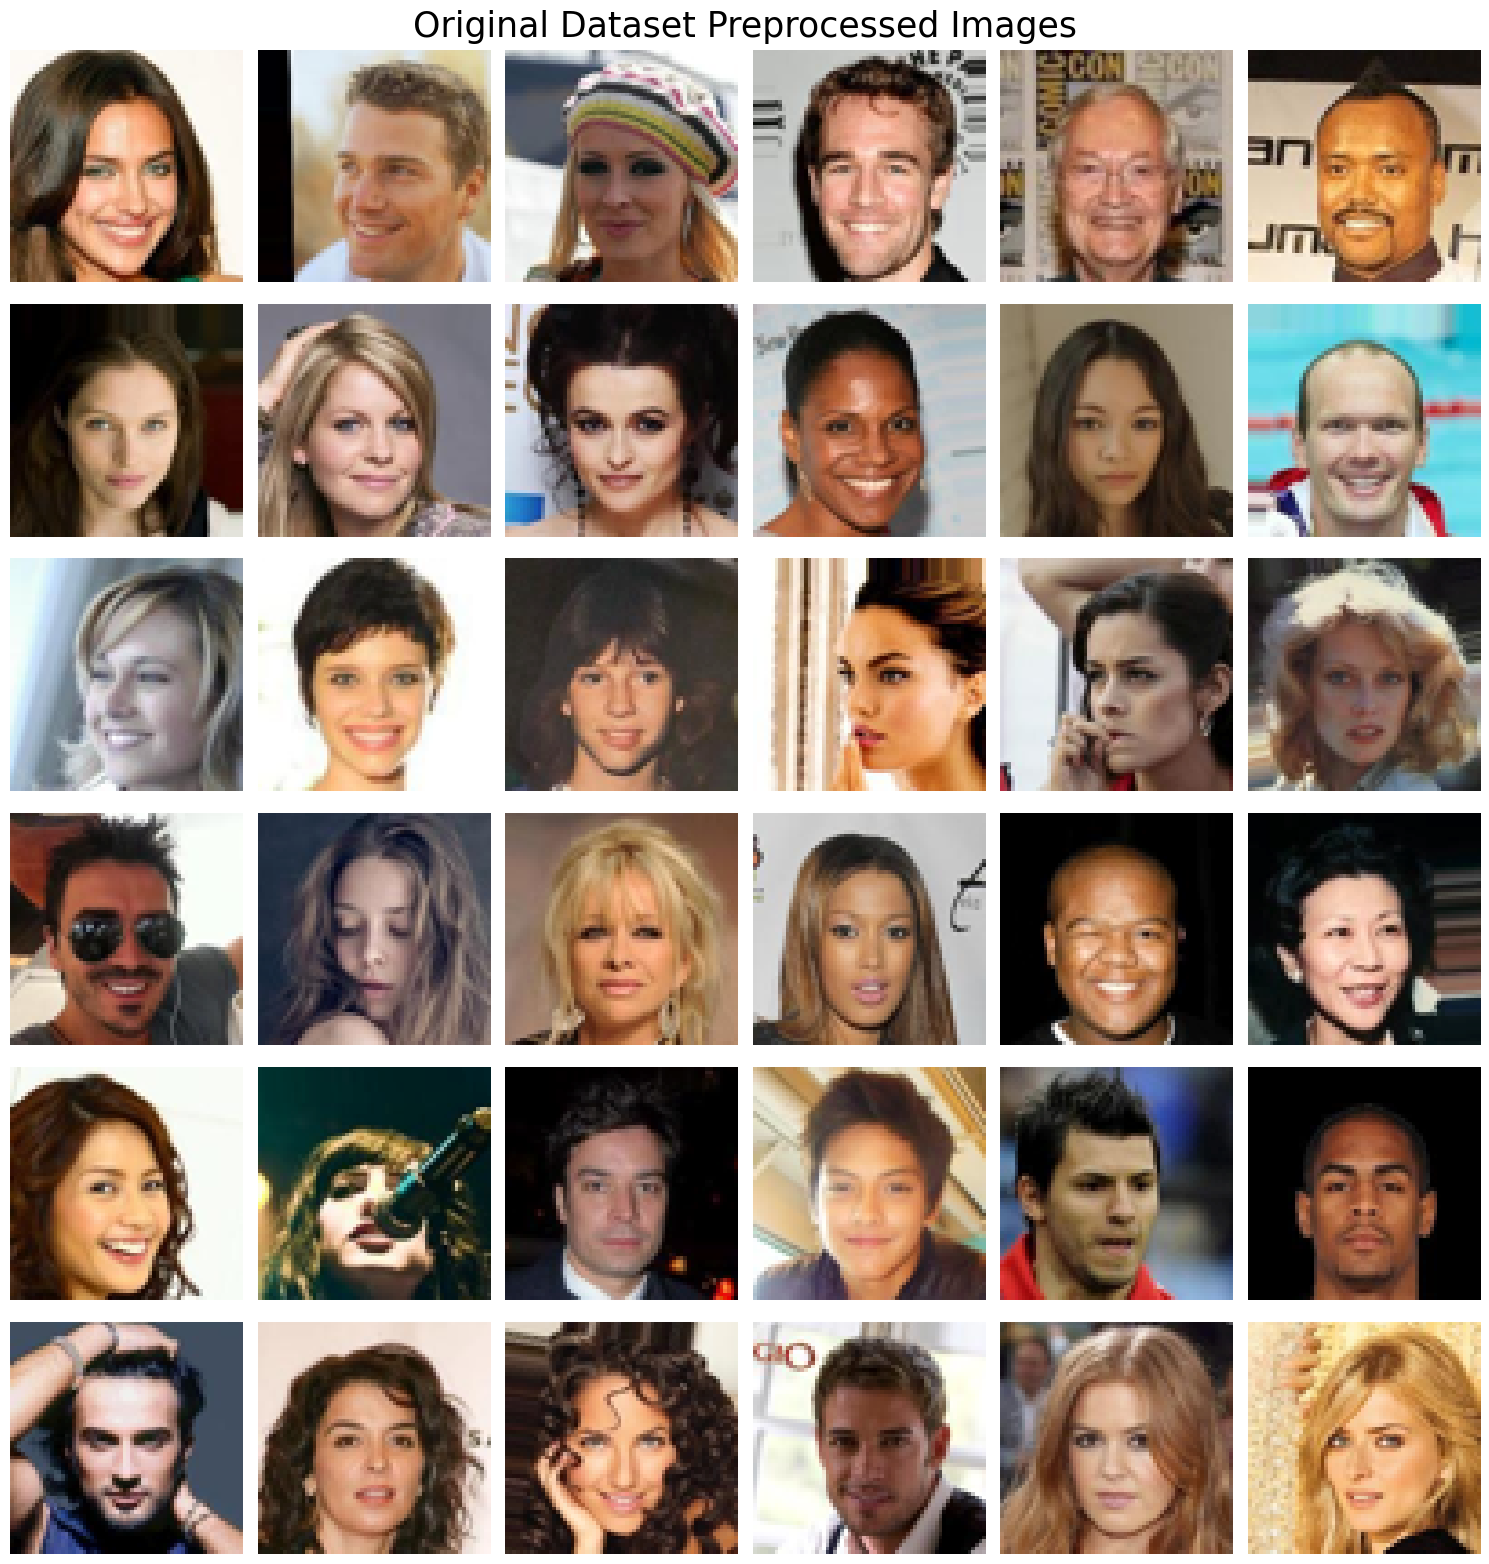

In [9]:
fig, axes = plt.subplots(6, 6, figsize=(15, 16))

for i, ax in enumerate(axes.flat):
    img = dataset[i]
    img_rescaled = (img + 1) / 2
    ax.imshow(img_rescaled)
    ax.axis('off')

fig.suptitle('Original Dataset Preprocessed Images', fontsize=25)

plt.tight_layout()
plt.show()

In [10]:
# generator
def build_generator(latent_dim):
    model = models.Sequential()
    model.add(layers.Dense(4 * 4 * 256, input_dim=latent_dim))
    model.add(layers.Reshape((4, 4, 256)))
    model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Conv2DTranspose(3, (4, 4), activation='tanh', padding='same'))
    return model

In [11]:
# discriminator
def build_discriminator(input_shape):
    model = models.Sequential()
    model.add(layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same', input_shape=input_shape))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

In [12]:
latent_dim = 100

# Build and compile the discriminator
discriminator = build_discriminator((64, 64, 3))
discriminator.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5), metrics=['accuracy'])
discriminator.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
/opt/conda/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │        16,385 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 387,201 (1.48 MB)

 Trainable params: 387,201 (1.48 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
generator = build_generator(latent_dim)
generator.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 4096)           │       413,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 128)      │       524,416 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 128)    │       262,272 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 64)     │       131,136 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 64, 64, 64)     │        65,600 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 64, 64, 3)      │         3,075 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,400,195 (5.34 MB)

 Trainable params: 1,400,195 (5.34 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
generator = build_generator(latent_dim)

# The generator takes noise as input and generates images
z = layers.Input(shape=(latent_dim,))
img = generator(z)

In [15]:
discriminator.trainable = False

# The discriminator takes generated images as input and determines validity
validity = discriminator(img)

# The combined model (stacked generator and discriminator)
combined = models.Model(z, validity)
combined.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5))

# **Running for 100 epochs**

In [16]:
import matplotlib.pyplot as plt

# Function to generate and display images
def generate_and_display_images(generator, latent_dim, num_samples=10):
    # Generate random noise
    noise = np.random.normal(0, 1, (num_samples, latent_dim))
    
    generated_images = generator.predict(noise)
    
    # Rescale images from [-1, 1] to [0, 1] for display
    generated_images = (generated_images + 1) / 2
    
    plt.figure(figsize=(15, 16))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i+1)
        plt.imshow(generated_images[i])
        plt.axis('off')
    plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step


I0000 00:00:1712419441.079836      92 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py:74: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Epoch 1, Discriminator Loss: 0.6917567849159241, Generator Loss: 0.6930167078971863
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Epoch 2, Discriminator Loss: 0.6905445456504822, Generator Loss: 0.6927123069763184
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Epoch 3, Discriminator Loss: 0.6910092830657959, Generator Loss: 0.6924335956573486
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Epoch 4, Discriminator Loss: 0.69107985496521, Generator Loss: 0.6921277046203613
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Epoch 5, Discriminator Loss: 0.6911207437515259, Generator Loss: 0.691769540309906
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Epoch 6, Discriminator Loss: 0.6916235685348511, Generator Loss: 0.6913453936576843
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Epoch 7, Discriminator Loss: 0.6920638084411621, Generator Loss: 0.6908025145530701
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Epoch 8, Discriminator Loss: 0.6922794580459595, Generator Loss: 0.6901507377624512
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Epoch 9, Discriminator Loss

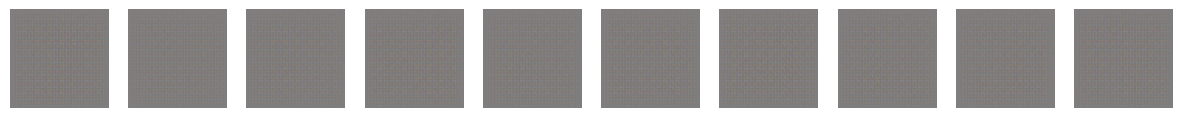

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Epoch 11, Discriminator Loss: 0.6935498714447021, Generator Loss: 0.6869494915008545
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Epoch 12, Discriminator Loss: 0.6943129301071167, Generator Loss: 0.6854018568992615
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Epoch 13, Discriminator Loss: 0.6951713562011719, Generator Loss: 0.6833409070968628
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Epoch 14, Discriminator Loss: 0.6962990164756775, Generator Loss: 0.6809504628181458
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Epoch 15, Discriminator Loss: 0.6976970434188843, Generator Loss: 0.6779636144638062
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Epoch 16, Discriminator Loss: 0.6995676159858704, Generator Loss: 0.6742131114006042
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Epoch 17, Discriminator Loss: 0.7016937732696533, Generator Loss: 0.670141339302063
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Epoch 18, Discriminator Loss: 0.7040543556213379, Generator Loss: 0.6654111742973328
4/4 ━━━━━━━━━━━━━

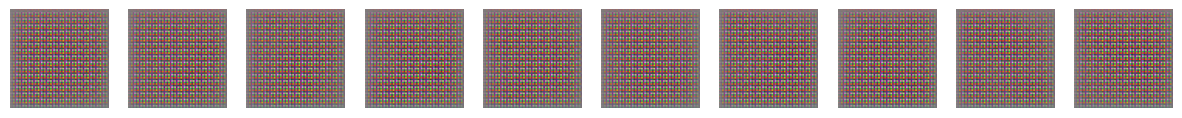

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Epoch 21, Discriminator Loss: 0.7132171392440796, Generator Loss: 0.6492403745651245
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Epoch 22, Discriminator Loss: 0.7164913415908813, Generator Loss: 0.6437384486198425
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Epoch 23, Discriminator Loss: 0.7199637293815613, Generator Loss: 0.6381557583808899
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Epoch 24, Discriminator Loss: 0.7235796451568604, Generator Loss: 0.6321539878845215
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Epoch 25, Discriminator Loss: 0.7273081541061401, Generator Loss: 0.6262180805206299
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Epoch 26, Discriminator Loss: 0.7311853170394897, Generator Loss: 0.620457112789154
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Epoch 27, Discriminator Loss: 0.7350159883499146, Generator Loss: 0.6148191690444946
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Epoch 28, Discriminator Loss: 0.7388097047805786, Generator Loss: 0.6091983914375305
4/4 ━━━━━━━━━━━━━

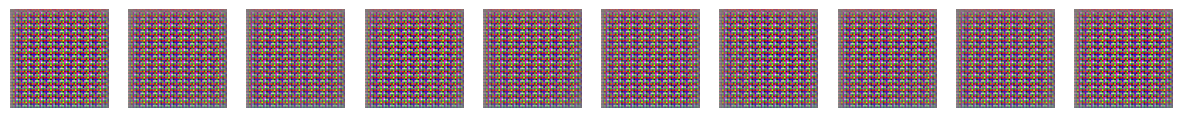

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Epoch 31, Discriminator Loss: 0.7501816153526306, Generator Loss: 0.5927718877792358
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Epoch 32, Discriminator Loss: 0.7540497183799744, Generator Loss: 0.5875434279441833
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Epoch 33, Discriminator Loss: 0.7578851580619812, Generator Loss: 0.5824813842773438
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Epoch 34, Discriminator Loss: 0.7615268230438232, Generator Loss: 0.5775982737541199
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Epoch 35, Discriminator Loss: 0.7650759220123291, Generator Loss: 0.5729011297225952
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Epoch 36, Discriminator Loss: 0.7685483694076538, Generator Loss: 0.568296492099762
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Epoch 37, Discriminator Loss: 0.7720530033111572, Generator Loss: 0.5639115571975708
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Epoch 38, Discriminator Loss: 0.7754623889923096, Generator Loss: 0.5595059394836426
4/4 ━━━━━━━━━━━━━

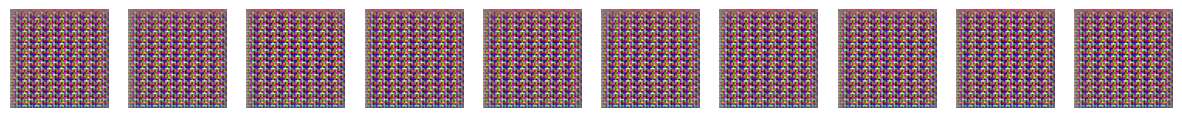

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Epoch 41, Discriminator Loss: 0.7851894497871399, Generator Loss: 0.547127366065979
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Epoch 42, Discriminator Loss: 0.788381814956665, Generator Loss: 0.5430939793586731
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Epoch 43, Discriminator Loss: 0.7915250062942505, Generator Loss: 0.5392694473266602
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Epoch 44, Discriminator Loss: 0.7946438789367676, Generator Loss: 0.5353711843490601
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Epoch 45, Discriminator Loss: 0.7976075410842896, Generator Loss: 0.5315563082695007
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Epoch 46, Discriminator Loss: 0.8005233407020569, Generator Loss: 0.5279453992843628
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Epoch 47, Discriminator Loss: 0.8033579587936401, Generator Loss: 0.5243817567825317
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Epoch 48, Discriminator Loss: 0.8062835931777954, Generator Loss: 0.5209888815879822
4/4 ━━━━━━━━━━━━━━

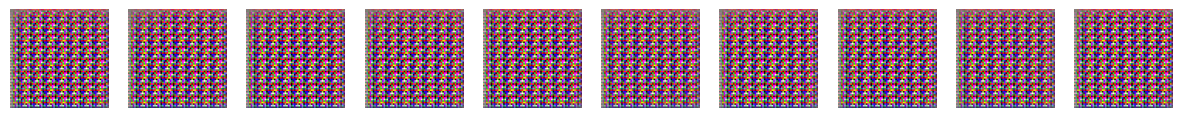

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Epoch 51, Discriminator Loss: 0.8148422241210938, Generator Loss: 0.511127769947052
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Epoch 52, Discriminator Loss: 0.8176186084747314, Generator Loss: 0.5079134106636047
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Epoch 53, Discriminator Loss: 0.8204222917556763, Generator Loss: 0.5046758651733398
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Epoch 54, Discriminator Loss: 0.8232194781303406, Generator Loss: 0.5015697479248047
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Epoch 55, Discriminator Loss: 0.8259381055831909, Generator Loss: 0.4985430836677551
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Epoch 56, Discriminator Loss: 0.8286668062210083, Generator Loss: 0.4955975115299225
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Epoch 57, Discriminator Loss: 0.8314268589019775, Generator Loss: 0.4926005005836487
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Epoch 58, Discriminator Loss: 0.834115743637085, Generator Loss: 0.4896460175514221
4/4 ━━━━━━━━━━━━━━

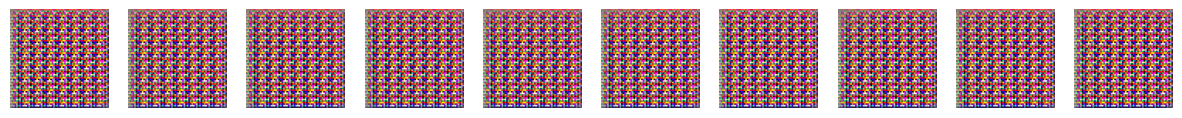

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Epoch 61, Discriminator Loss: 0.841961681842804, Generator Loss: 0.481418639421463
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Epoch 62, Discriminator Loss: 0.844491720199585, Generator Loss: 0.4787226915359497
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Epoch 63, Discriminator Loss: 0.8470895886421204, Generator Loss: 0.47612378001213074
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Epoch 64, Discriminator Loss: 0.8496339321136475, Generator Loss: 0.47340619564056396
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Epoch 65, Discriminator Loss: 0.8522062301635742, Generator Loss: 0.47080934047698975
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Epoch 66, Discriminator Loss: 0.8547341823577881, Generator Loss: 0.46823808550834656
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Epoch 67, Discriminator Loss: 0.857184886932373, Generator Loss: 0.465713769197464
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Epoch 68, Discriminator Loss: 0.8595602512359619, Generator Loss: 0.46325093507766724
4/4 ━━━━━━━━━━━━

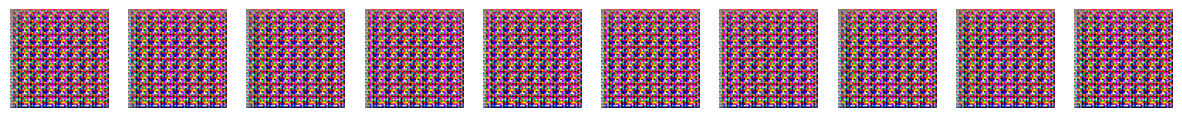

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Epoch 71, Discriminator Loss: 0.8668897747993469, Generator Loss: 0.4559347629547119
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Epoch 72, Discriminator Loss: 0.8693089485168457, Generator Loss: 0.4535437822341919
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Epoch 73, Discriminator Loss: 0.8716895580291748, Generator Loss: 0.45121195912361145
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Epoch 74, Discriminator Loss: 0.8740268349647522, Generator Loss: 0.4489816129207611
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Epoch 75, Discriminator Loss: 0.8763784170150757, Generator Loss: 0.4467034339904785
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Epoch 76, Discriminator Loss: 0.8786834478378296, Generator Loss: 0.4445357024669647
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Epoch 77, Discriminator Loss: 0.880905270576477, Generator Loss: 0.4423576891422272
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Epoch 78, Discriminator Loss: 0.8831422328948975, Generator Loss: 0.4402065873146057
4/4 ━━━━━━━━━━━━

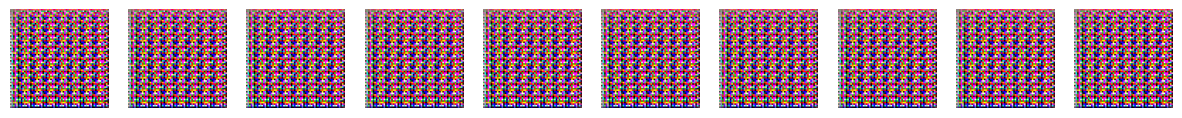

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Epoch 81, Discriminator Loss: 0.8898591995239258, Generator Loss: 0.4337855279445648
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Epoch 82, Discriminator Loss: 0.8920770883560181, Generator Loss: 0.4317728281021118
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Epoch 83, Discriminator Loss: 0.8942416906356812, Generator Loss: 0.4297269582748413
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Epoch 84, Discriminator Loss: 0.8964219093322754, Generator Loss: 0.4276973307132721
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Epoch 85, Discriminator Loss: 0.8986577987670898, Generator Loss: 0.4256666898727417
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Epoch 86, Discriminator Loss: 0.9008731842041016, Generator Loss: 0.42372632026672363
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Epoch 87, Discriminator Loss: 0.9030665755271912, Generator Loss: 0.42177891731262207
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Epoch 88, Discriminator Loss: 0.9052443504333496, Generator Loss: 0.4198820888996124
4/4 ━━━━━━━━━━

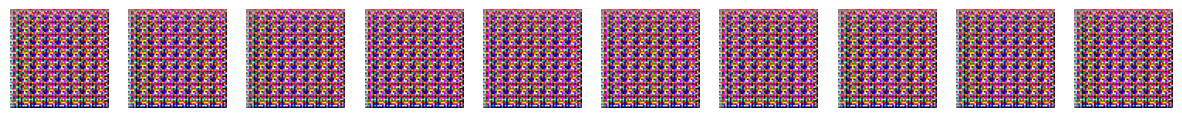

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Epoch 91, Discriminator Loss: 0.9113655686378479, Generator Loss: 0.4143398106098175
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Epoch 92, Discriminator Loss: 0.9134749174118042, Generator Loss: 0.41251033544540405
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Epoch 93, Discriminator Loss: 0.9155316352844238, Generator Loss: 0.41073185205459595
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Epoch 94, Discriminator Loss: 0.9175923466682434, Generator Loss: 0.4089570939540863
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Epoch 95, Discriminator Loss: 0.9196595549583435, Generator Loss: 0.4071793556213379
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Epoch 96, Discriminator Loss: 0.9216951131820679, Generator Loss: 0.4054287374019623
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Epoch 97, Discriminator Loss: 0.9237382411956787, Generator Loss: 0.40368276834487915
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Epoch 98, Discriminator Loss: 0.9257469177246094, Generator Loss: 0.4019821882247925
4/4 ━━━━━━━━━

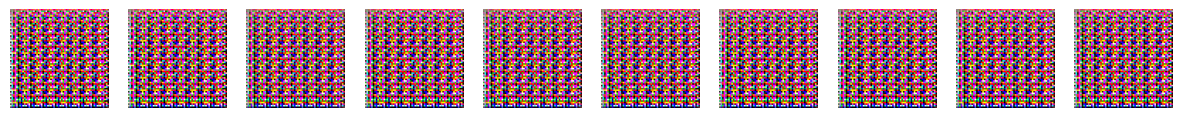

In [17]:
# Define a function to train the GAN
def train_gan(generator, discriminator, combined, images, latent_dim, epochs=100, batch_size=128):
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    for epoch in range(epochs):
        idx = np.random.randint(0, images.shape[0], batch_size)
        real_imgs = images[idx]
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        gen_imgs = generator.predict(noise)
        
        d_loss_real = discriminator.train_on_batch(real_imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        g_loss = combined.train_on_batch(noise, real)
        
        print(f"Epoch {epoch+1}, Discriminator Loss: {d_loss[0]}, Generator Loss: {g_loss}")
        
        if (epoch + 1) % 10 == 0:
            generate_and_display_images(generator, latent_dim, num_samples=10)

# Train the GAN
train_gan(generator, discriminator, combined, dataset, latent_dim, epochs=100, batch_size=128)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


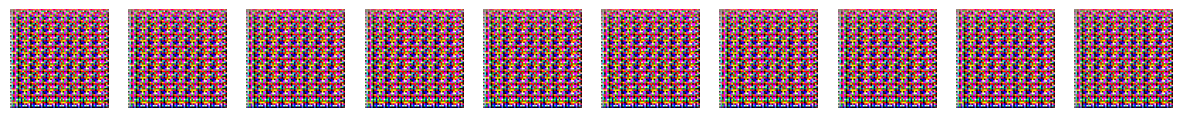

In [18]:
generate_and_display_images(generator, latent_dim, num_samples=10)